# Notebook - Análise da evasão

Dados do Instituto de Ciências Exatas (IE).

### Importando bibliotecas:

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

import utils
import process
import pre_process

%matplotlib inline

 ### Leitura dos dados

In [33]:
DATA_FILE = '../data/ie_data.csv'
data_pre = pd.read_csv(DATA_FILE, sep=';', low_memory=False)

## Pré-Processamento

In [34]:
attrs = []
cat_attr = ['course', 'quota_type', 'entry']
data_pre = pre_process.format_data(data_pre)
data_pre = pre_process.erase_attr(data_pre)


initial_year = 2010
data_pre = pre_process.time_frame(data_pre, initial_year)

horizon = 1  # 1 year = 2 semesters
data_pre = pre_process.beyond_horizon(data_pre, horizon)

data_pre = pre_process.public_school(data_pre, attrs)
data_pre = pre_process.dropout(data_pre, attrs)
data_pre = pre_process.course(data_pre, attrs)
data_pre = pre_process.gender(data_pre, attrs)
data_pre = pre_process.entry(data_pre, attrs)
data_pre = pre_process.age(data_pre, attrs)

data_pre = pre_process.cic_courses(data_pre)
data_pre = pre_process.erase_interal_transfer_students(data_pre)

credits_dict = pre_process.subject_credits(data_pre)

data_pre = pre_process.quota(data_pre, attrs)
attrs.extend(['quota_type', 'entry'])
# data_pre = pre_process.one_hot_encoding(data_pre, ['quota_type', 'entry'], attrs)
data_pre = data_pre.dropna()

In [ ]:
# Reload module
import importlib
importlib.reload(pre_process)

Divide dataframe by course:

In [35]:
data_course = pre_process.divide_course(data_pre)
data_course['all'] = data_pre

Remove course attribute from individual dataframes:

(Preciso remodelar o pipeline antes de retirar esse atributo)

In [ ]:
# for course in keys:
#     if course != 'all':
#         data_course[course].drop('course', axis=1, inplace=True)

### Process Subjects and CEP

The Subjects are processed for each course individually, and Cep needs to be processed before all other attributes and drop_duplicates, otherwise it takes too long to process.

In [36]:
keys = data_course.keys()
data_analysis = {}
for course in keys:
    print(course)
    data = data_course[course].copy()
    attrs_copy = attrs.copy()

    # Process subjects
    data = pre_process.add_semester_prefix(data)
    data = pre_process.subjects(data, attrs_copy, horizon, credits_dict)

    # Process CEP
    # It needs to be processed before drop_duplicates, or it takes too long to process.
    data = data[attrs_copy+['cep', 'aluno']].drop_duplicates()
    data = pre_process.cep(data, attrs_copy)

    data_analysis[course] = data.copy()  # make a copy for data analysis
    data = data[attrs_copy].drop_duplicates()
    data_course[course] = data.copy()

ciência da computação
computação
engenharia de computação
engenharia mecatrônica
all


In [37]:
data_process = data_course.copy()

## Analysis

Tamanho da base:

In [17]:
for course in data_course.keys():
    print(f'{course} = {data_course[course].shape}')
    print(f'quota \n{data_course[course]["quota"].value_counts()}')
    print('\n')

ciência da computação = (597, 50)
quota 
False    458
True     139
Name: quota, dtype: int64


computação = (603, 50)
quota 
False    494
True     109
Name: quota, dtype: int64


engenharia de computação = (517, 50)
quota 
False    390
True     127
Name: quota, dtype: int64


engenharia mecatrônica = (449, 50)
quota 
False    357
True      92
Name: quota, dtype: int64


all = (2166, 50)
quota 
False    1699
True      467
Name: quota, dtype: int64




Desbalanceamento da base:

In [8]:
for course in data_course.keys():
    print(f'{course}:')
    freq = data_course[course]['dropout'].value_counts()
    print(freq)
    print('\n')

ciência da computação:
True     442
False    155
Name: dropout, dtype: int64


computação:
True     494
False    109
Name: dropout, dtype: int64


engenharia de computação:
True     343
False    174
Name: dropout, dtype: int64


engenharia mecatrônica:
True     277
False    172
Name: dropout, dtype: int64


all:
True     1556
False     610
Name: dropout, dtype: int64




## Testes

In [ ]:
data_pre['quota_type'].value_counts()

In [ ]:
data_pre.columns

## Processamento

In [40]:
def catboost(data):
    output_attr = 'dropout'

    X = data.drop(columns=[output_attr])
    y = data[output_attr]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )   

    # dropout imbalance
    output_freq = data[output_attr].value_counts()
    scale = output_freq[0] / output_freq[1]  # negative / positive

    model = CatBoostClassifier(scale_pos_weight=scale, depth=5, one_hot_max_size=4)
    model.fit(
        X_train, y_train,
        cat_features=cat_attr, plot=False, silent=True
    )
    # print(model.get_all_params())

    process.show_metrics(model, X_train, y_train, X_test, y_test)
    # utils.precision_recall_graph(model, X_test, y_test)

    # shap importance
    shap_values = model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=cat_attr), 
        type="ShapValues"
    )
    shap_values = shap_values[:,:-1]
    shap.summary_plot(
        shap_values, X_test, 
        plot_type='bar', 
        plot_size=(15,15),
        max_display=30
    )

    return model, X_test

Process all dataframes:


Curso = ciência da computação
Treino:
    Accuracy = 93.53%
    Precision = 92.22%
    Recall = 99.68%
    FScore = 97.26%
Teste:
    Accuracy = 84.44%
    Precision = 84.77%
    Recall = 96.24%
    FScore = 92.39%


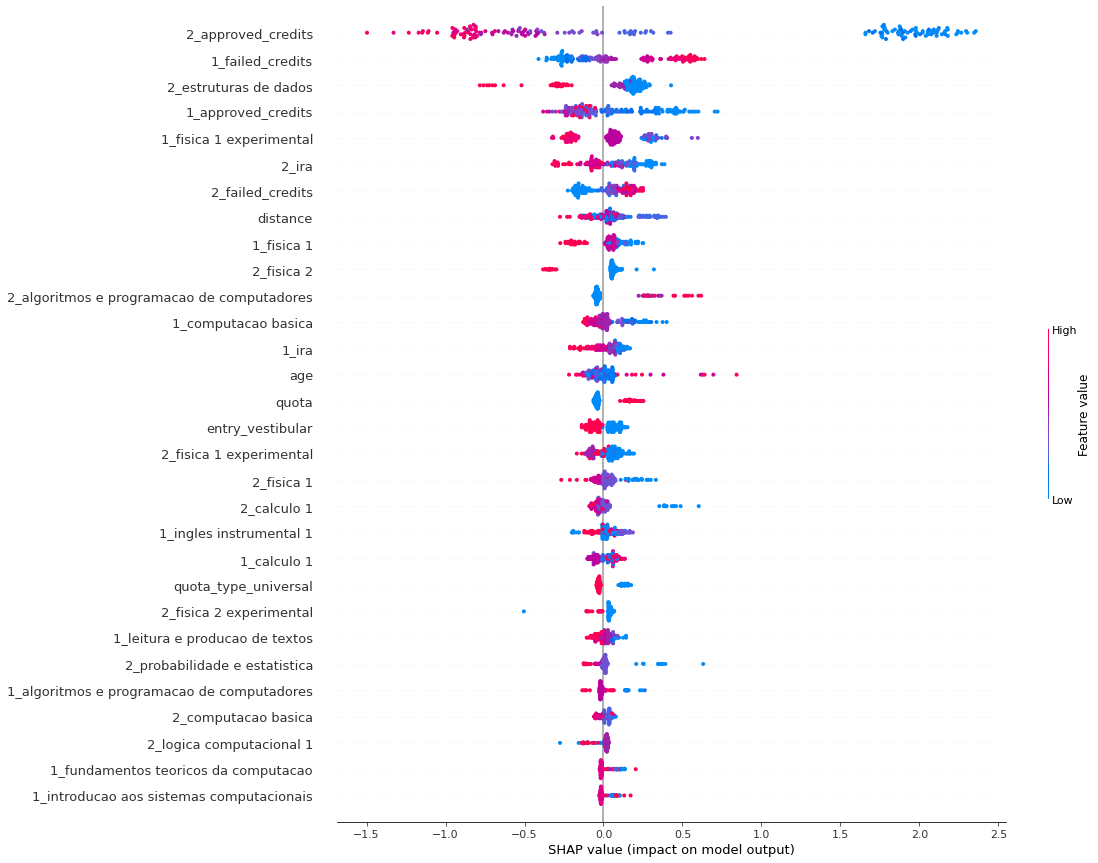


Curso = computação
Treino:
    Accuracy = 98.34%
    Precision = 98.02%
    Recall = 100.00%
    FScore = 99.38%
Teste:
    Accuracy = 83.43%
    Precision = 85.12%
    Recall = 96.62%
    FScore = 92.76%


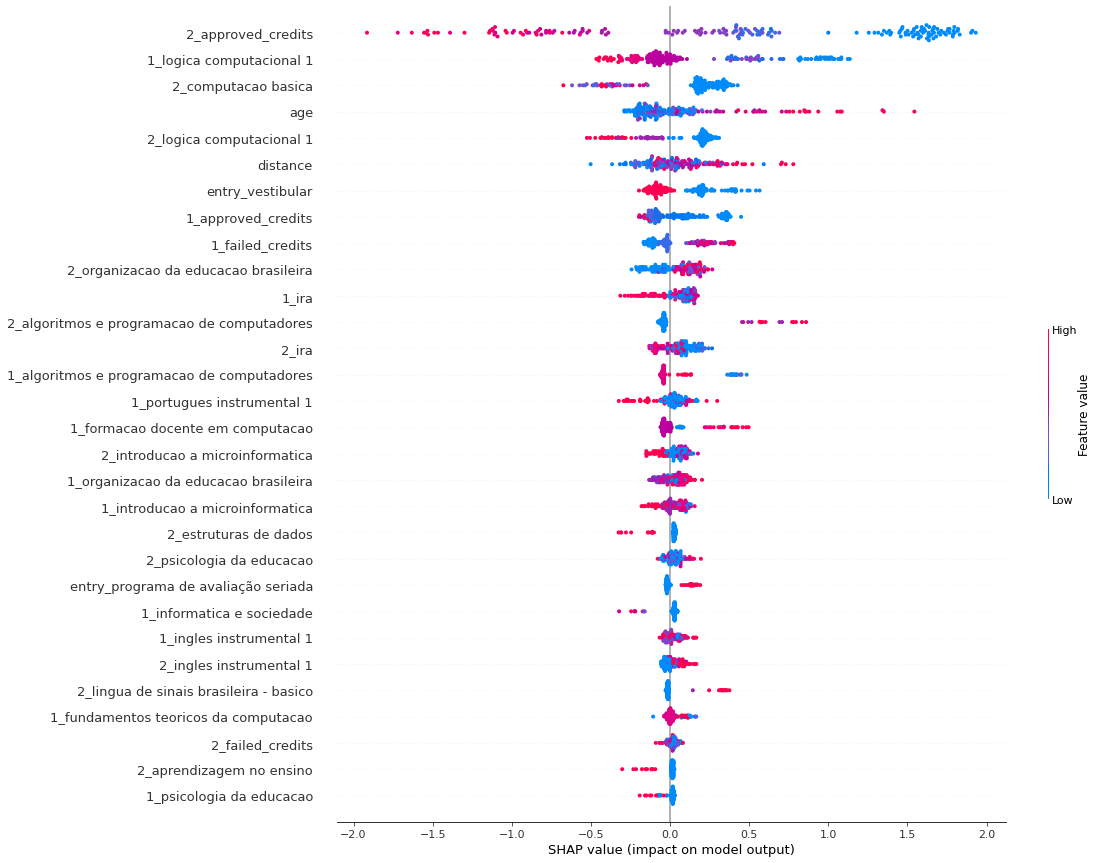


Curso = engenharia de computação
Treino:
    Accuracy = 94.18%
    Precision = 94.33%
    Recall = 97.08%
    FScore = 96.22%
Teste:
    Accuracy = 75.64%
    Precision = 77.31%
    Recall = 89.32%
    FScore = 85.25%


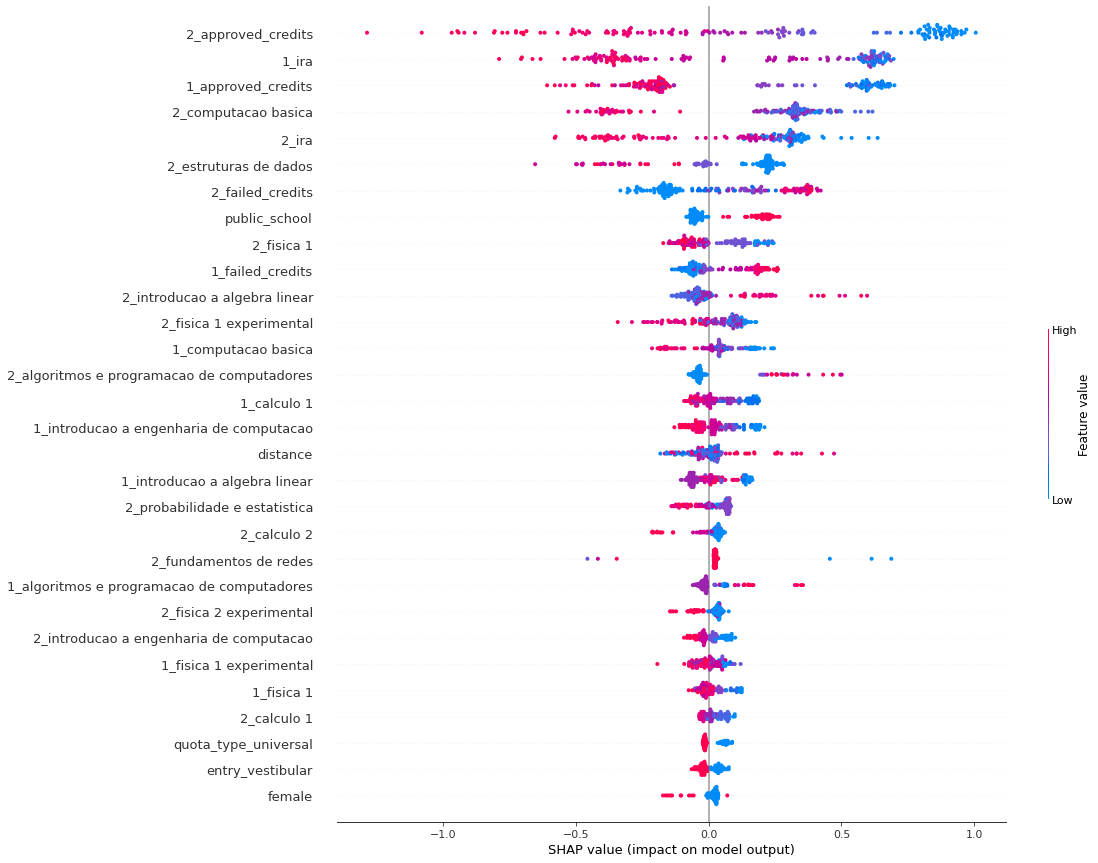


Curso = engenharia mecatrônica
Treino:
    Accuracy = 88.85%
    Precision = 86.30%
    Recall = 97.42%
    FScore = 93.71%
Teste:
    Accuracy = 71.85%
    Precision = 72.28%
    Recall = 87.95%
    FScore = 82.45%


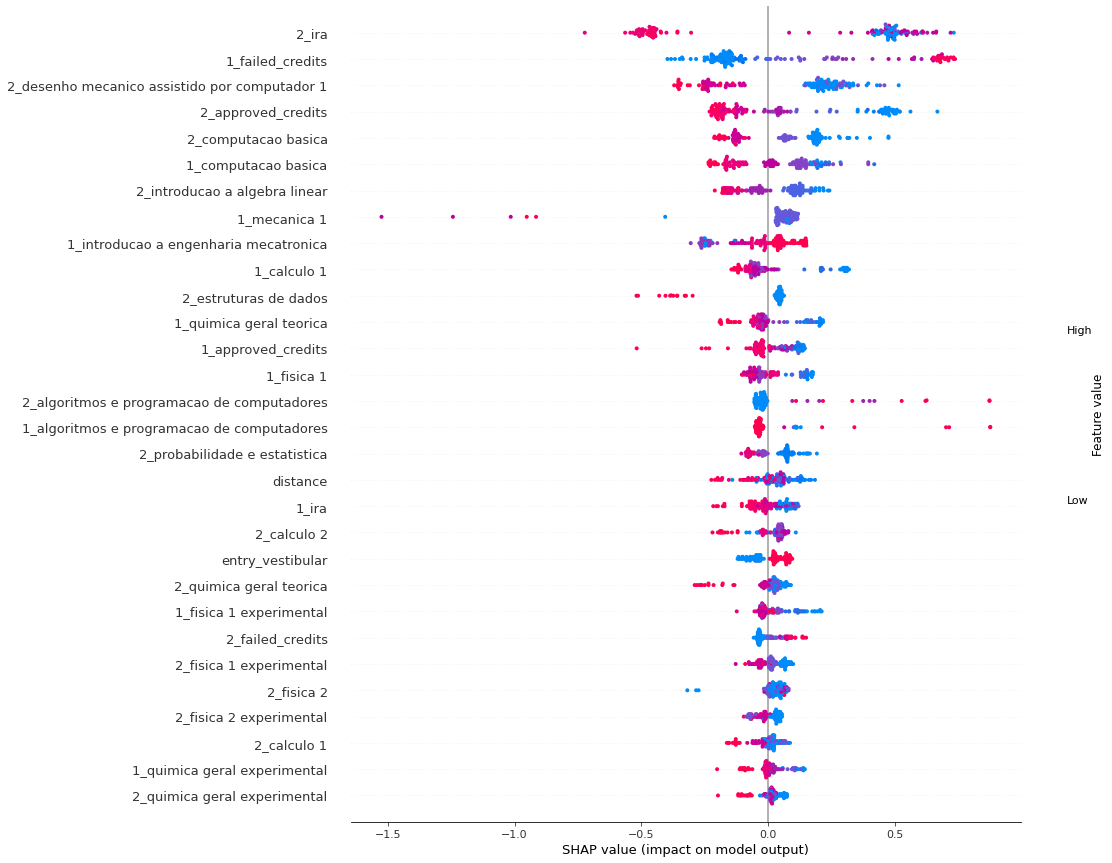


Curso = all
Treino:
    Accuracy = 91.42%
    Precision = 92.17%
    Recall = 96.24%
    FScore = 94.95%
Teste:
    Accuracy = 80.00%
    Precision = 84.18%
    Recall = 88.87%
    FScore = 87.37%


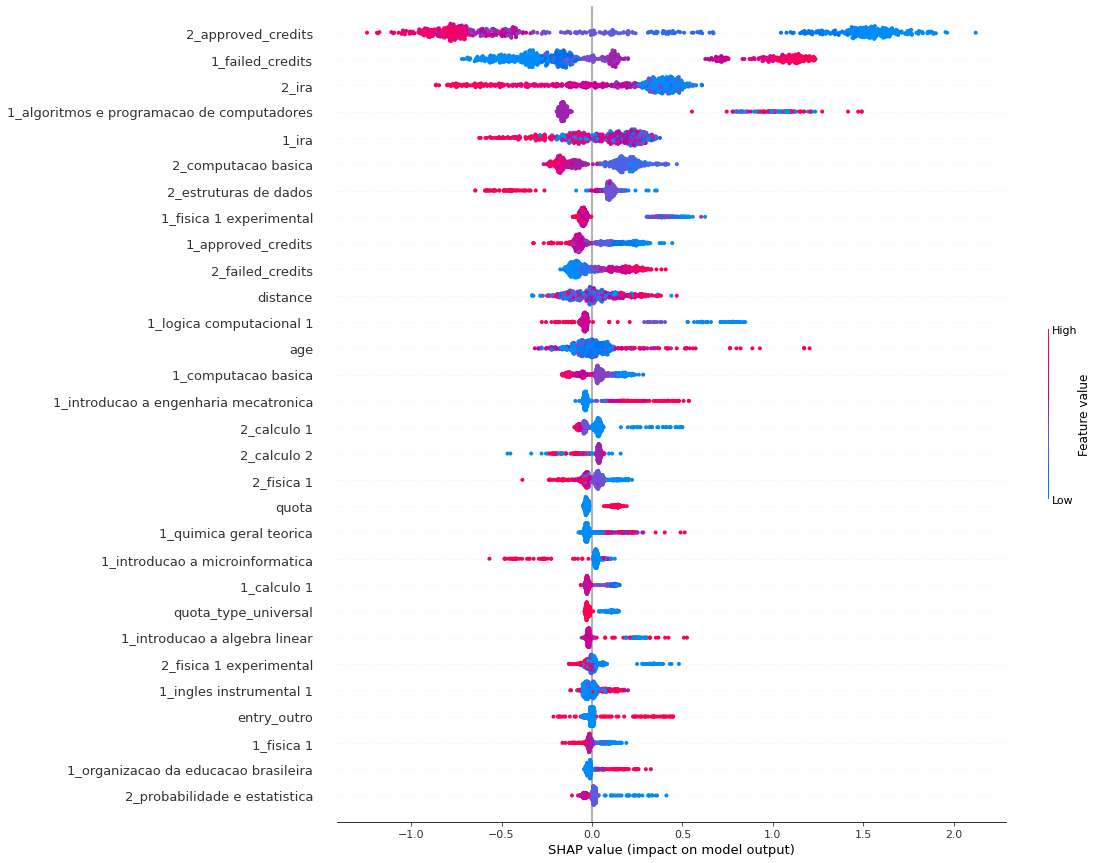

In [12]:
for course, data in data_process.items():
    print(f'\nCurso = {course}')
    model, X_test = catboost(data)


Curso = ciência da computação
Treino:
    Accuracy = 92.33%
    Precision = 91.84%
    Recall = 98.38%
    FScore = 96.27%
Teste:
    Accuracy = 83.33%
    Precision = 85.03%
    Recall = 93.98%
    FScore = 91.04%


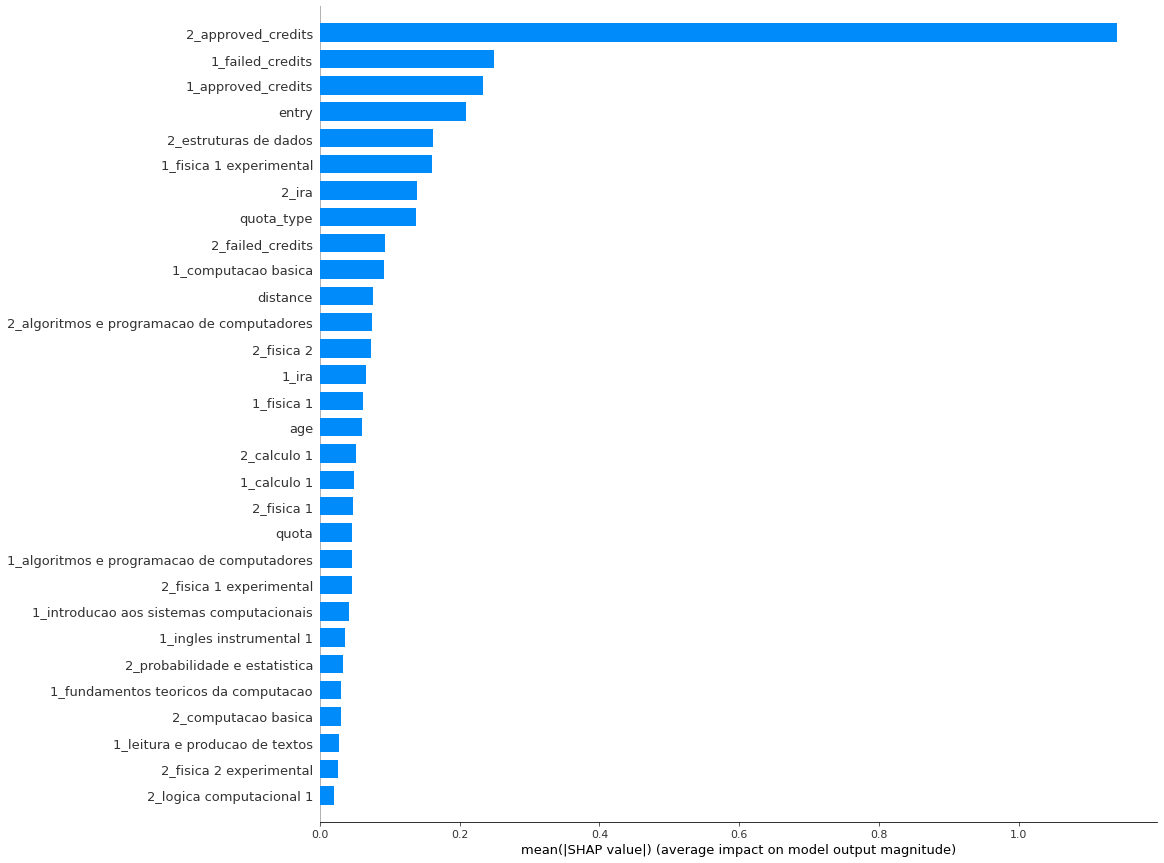


Curso = computação
Treino:
    Accuracy = 98.10%
    Precision = 98.01%
    Recall = 99.71%
    FScore = 99.18%
Teste:
    Accuracy = 82.87%
    Precision = 85.89%
    Recall = 94.59%
    FScore = 91.73%


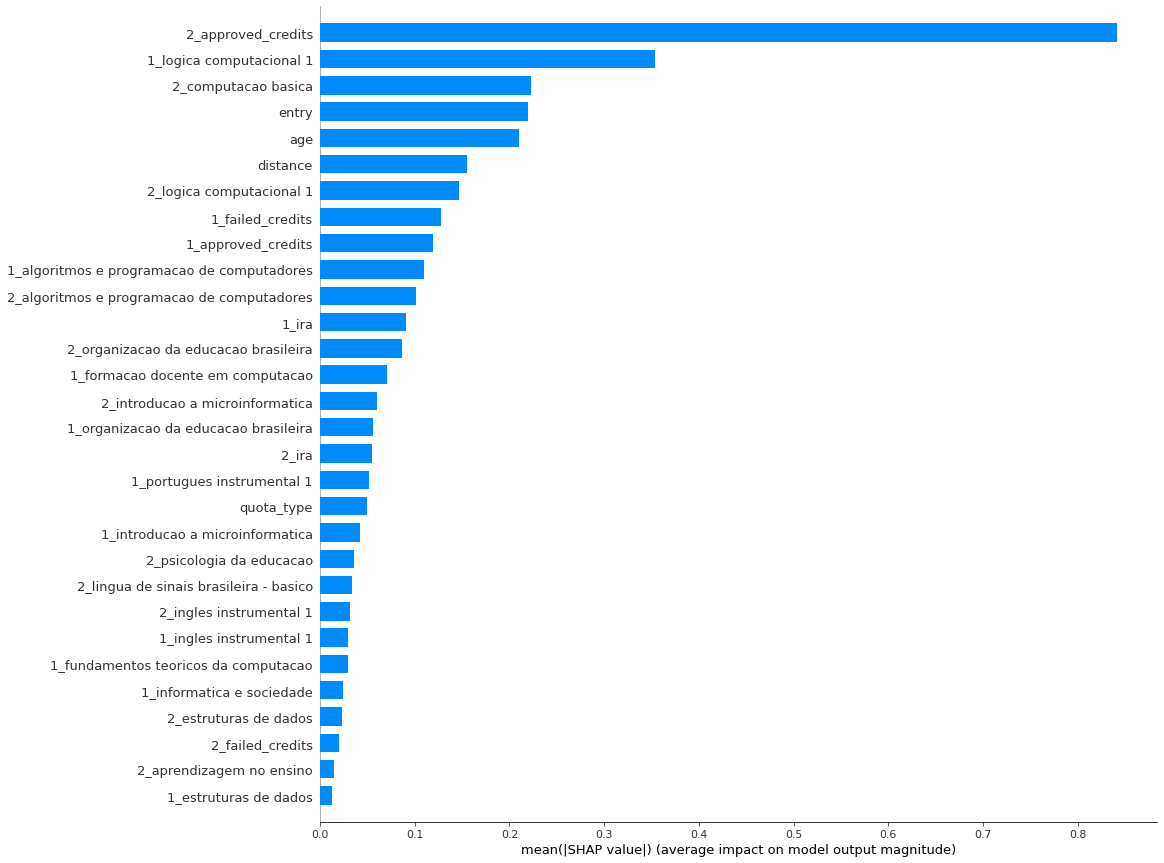


Curso = engenharia de computação
Treino:
    Accuracy = 92.24%
    Precision = 91.41%
    Recall = 97.50%
    FScore = 95.54%
Teste:
    Accuracy = 75.64%
    Precision = 76.42%
    Recall = 91.26%
    FScore = 86.12%


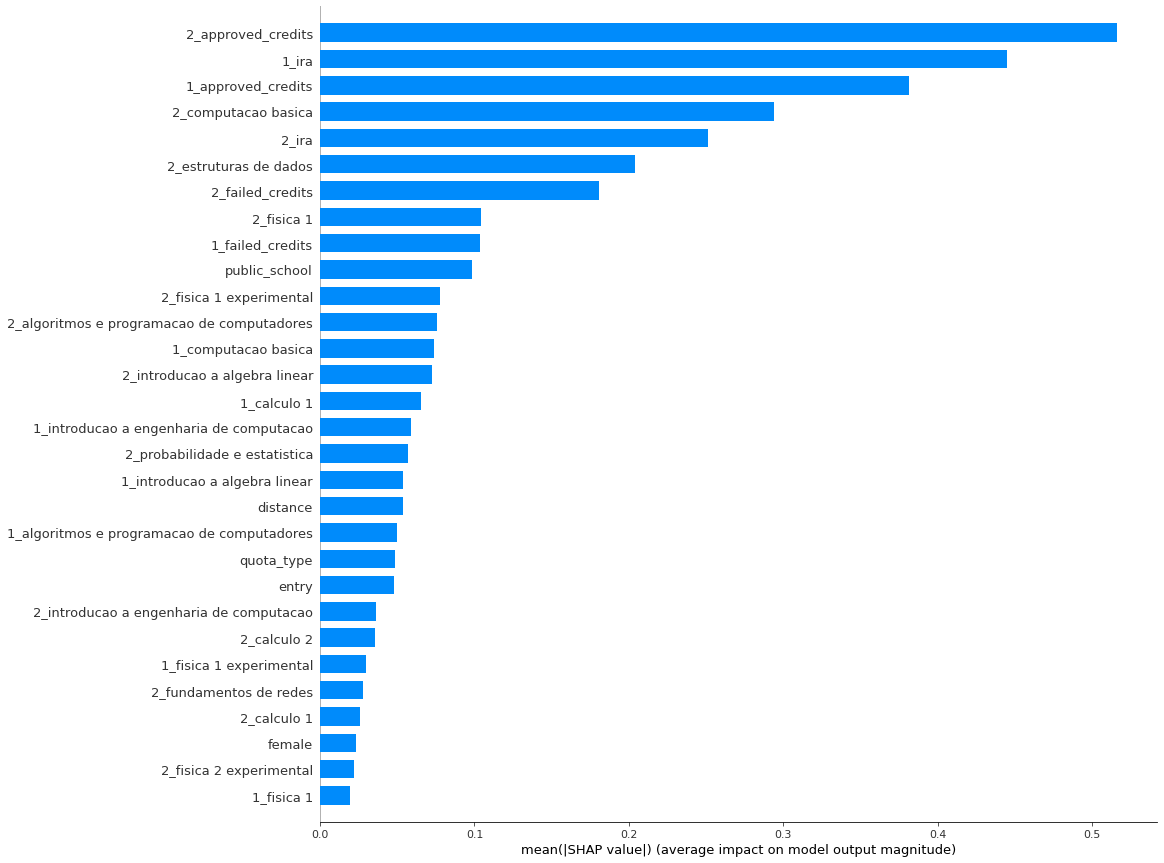


Curso = engenharia mecatrônica
Treino:
    Accuracy = 85.67%
    Precision = 82.25%
    Recall = 97.94%
    FScore = 92.51%
Teste:
    Accuracy = 74.07%
    Precision = 72.64%
    Recall = 92.77%
    FScore = 85.48%


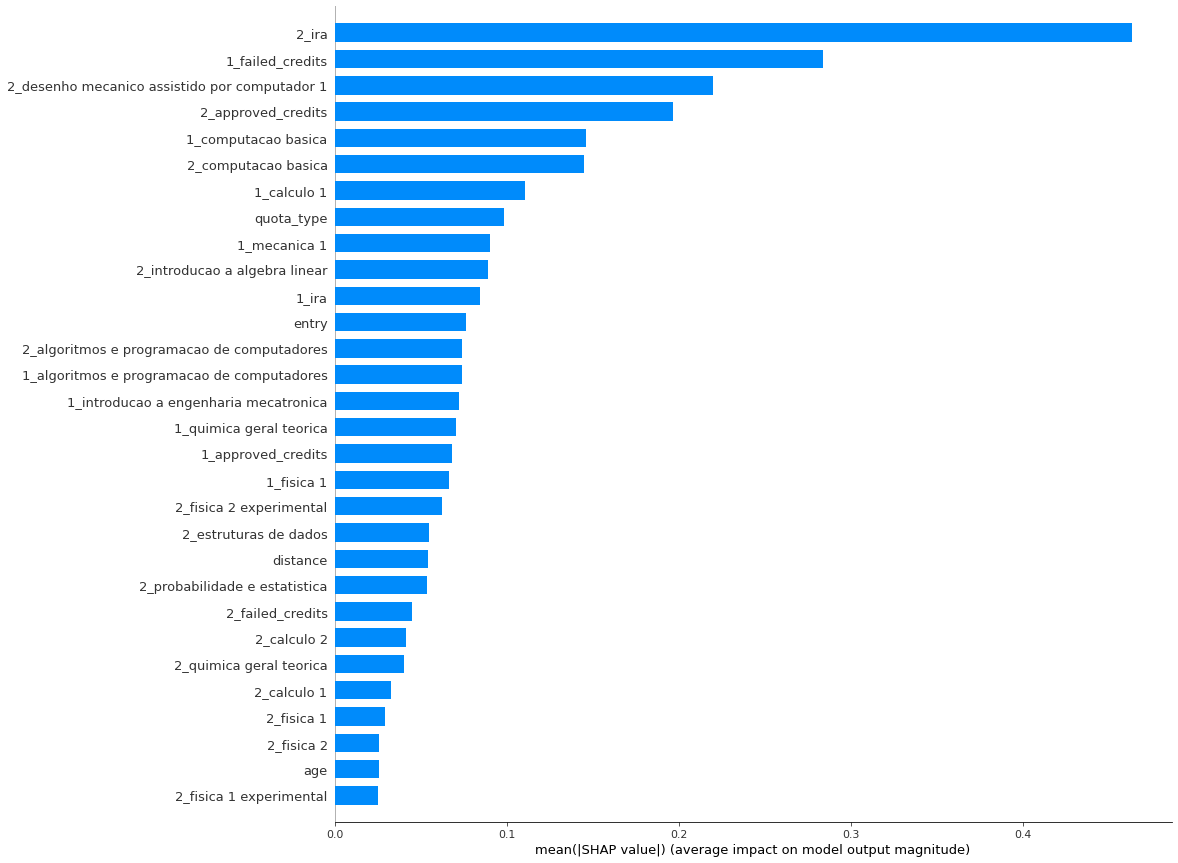


Curso = all
Treino:
    Accuracy = 90.30%
    Precision = 90.60%
    Recall = 96.51%
    FScore = 94.61%
Teste:
    Accuracy = 79.69%
    Precision = 83.17%
    Recall = 89.94%
    FScore = 87.74%


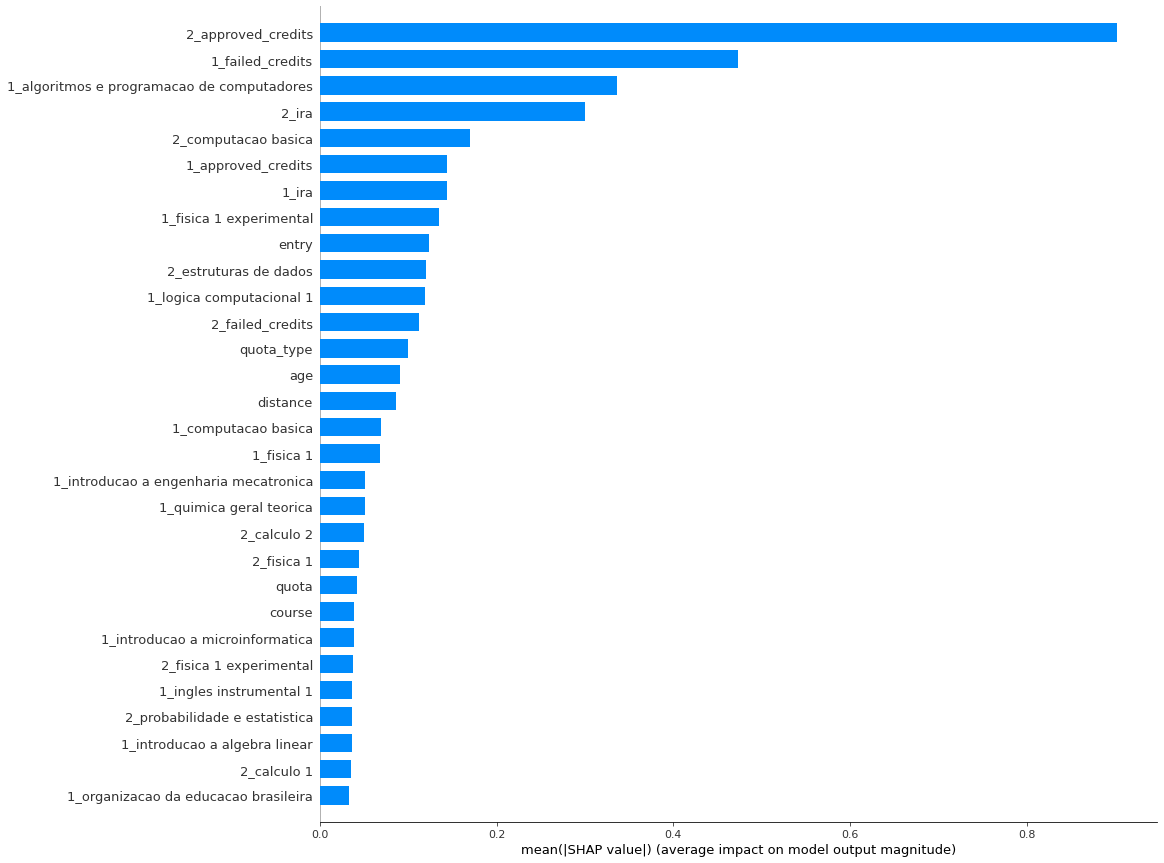

In [41]:
for course, data in data_process.items():
    print(f'\nCurso = {course}')
    model, X_test = catboost(data)

Process a single dataframe:

In [ ]:
course = 'computação'
model, X_test = catboost(data_process[course])

## Using SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
start_index = 0
end_index = len(X_test)
shap_values = explainer.shap_values(X_test[start_index:end_index])

shap.initjs()

In [ ]:
id = 23
shap.force_plot(explainer.expected_value,
                shap_values[id:id+1],
                X_test[id:id+1])

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test[start_index:end_index])

In [ ]:
shap.summary_plot(shap_values, X_test[start_index:end_index], plot_size=(20,20), max_display=50)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=50)

In [ ]:
shap.dependence_plot('1_ira', shap_values, X_test[start_index:end_index], interaction_index='distance')

## Plot Student's House Coordinates

In [ ]:
attr = ['aluno', 'cep', 'dropout', 'course']
# keys = data_analysis.keys()
keys = ['computação']
for course in keys:
    data = data_analysis[course].copy()[attr].drop_duplicates()
    utils.plot_coordinates(data, course)
#     utils.plot_coordinates_density(data, course)